In [11]:
import cv2
import numpy as np
import math
import copy
import open3d as o3d
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import glob
import os
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import time
# Reshapes the input depth image to a numpy array format.
def get_depth_np(img):
    depth_np = img.reshape(img.shape[0]*img.shape[1], 3)
    return depth_np

# Filters points in the depth numpy array based on their 
# heights within a specified range.
def Filter_by_height(img,depth_np):
    heights=depth_np[:,2]
    print("heights.max(): ",heights.max())
    print("heights.min():",heights.min())
    min_height=heights.min()+1.5
    max_height=heights.max()-3.05
    mask = (heights >= min_height) & (heights <= max_height)
    filtered_ndarray = depth_np[mask]
    print("filtered points number: ",filtered_ndarray.shape[0])
    return filtered_ndarray

# Converts a numpy array to an Open3D point cloud object.
def NDarray2Pcd(ndarray):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ndarray)
    print("pcd_size: ",len(pcd.points))
    return pcd

# Downsamples a point cloud using voxel grid downsampling.
def down_sample(pcd,voxel_size):
    pcd_down= pcd.voxel_down_sample(voxel_size)
    return pcd_down

# Removes statistical outliers from a point cloud.
def statistical_filter(pcd,num_neighbors,std_ratio):
    # return sor_pcd and cooresponding index
    sor_pcd, ind = pcd.remove_statistical_outlier(num_neighbors, std_ratio)
    print("sor_pcd：", sor_pcd)
    sor_pcd.paint_uniform_color([0, 0, 1])
    sor_noise_pcd = pcd.select_by_index(ind, invert=True)
#     o3d.visualization.draw_geometries([sor_pcd])
    print("sor_noise_pcd：", sor_noise_pcd)
    return sor_pcd

# Segments the top plane from a point cloud.
def find_top_plane(pcd):
#     o3d.visualization.draw_geometries([pcd])
    pcd_planes = [] 
    # 重复执行直到点云为空
    while len(pcd.points) > 1000:
        # 计算点云法向量
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=0.1, max_nn=30))
        # 分割平面
        plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                                 ransac_n=3,
                                                 num_iterations=1000)
        # 提取平面点集
        plane_points = pcd.select_by_index(inliers)
        # 计算平面中心和法向量
        plane_center = plane_points.get_center()
        plane_normal = plane_model[:3]
        # 计算平面边界框
        bbox = plane_points.get_axis_aligned_bounding_box()
        # 可视化平面边界框和法向量
        bbox.color = (1, 0, 0)
        pcd_planes.append(plane_points) 
        # 从点云中移除该平面上的点
        pcd = pcd.select_by_index(inliers, invert=True)
    plane_num=len(pcd_planes)
    print('plane_num:',plane_num)
    z_mean_max=100
    for i in range(plane_num):
#         定义料框边框的范围
        min_bound=np.array([0.16745114, -0.35435218, 1.5])
        max_bound=np.array([0.56981939, 0.24470487, 1.8])
        min1 = pcd_planes[i].get_min_bound()
        max1 = pcd_planes[i].get_max_bound()
        print("min1:",min1)
        print("max1:",max1)
#         定义料框边框内部范围
        min_bound[0] += 0.03  
        min_bound[1] += 0.03  
        max_bound[0] -= 0.03  
        max_bound[1] -= 0.03  
        bounding_box = o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)
        cropped_cloud = pcd_planes[i].crop(bounding_box) 
        bounding_box.color = (1, 0, 0)
#         o3d.visualization.draw_geometries([pcd_planes[i],bounding_box])
#     如果内部没有足够的点，就不是我们想要的平面    
    has_points = len(cropped_cloud.points) > 20
        if has_points:
            print("空间区域内有点云数据.")
        else:
            print("空间区域内没有点云数据.")
        pcd_points = np.asarray(pcd_planes[i].points)
        z_mean = np.mean(pcd_points[:, 2])
        if z_mean<z_mean_max and len(pcd_planes[i].points)>300 and has_points==1:
            z_mean_max=z_mean
            top_plane=pcd_planes[i]
    top_plane, _ = top_plane.remove_statistical_outlier(nb_neighbors=20,std_ratio=2.0)
#     o3d.visualization.draw_geometries([top_plane])
    return top_plane

# 这个函数暂时用不到
# Segments the surface of a box using DBSCAN clustering.
def segment_box_surface(top_plane, cluster_distance, cluster_min_points):
    # apply the DBSCAN clustering algorithm 
    labels = np.array(top_plane.cluster_dbscan(eps=cluster_distance, 
                                               min_points=cluster_min_points, 
                                               print_progress=True))
    # calculate the number of clusters 
    num_clusters = labels.max()+1
    print("cluster number:", num_clusters)

    # find clusters with at least 100 points
    large_clusters = [i for i in range(num_clusters) if np.sum(labels == i) > 100]

    if len(large_clusters) == 0:
        print("No cluster has more than 100 points.")
        return None

    # find the cluster with the smallest average z-axis coordinate
    cluster_z = []
    for i in large_clusters:
        indices = [j for j in range(len(labels)) if labels[j] == i]
        z_coords = [top_plane.points[j][2] for j in indices]
        cluster_z.append((i, np.mean(z_coords)))
    smallest_z_cluster = min(cluster_z, key=lambda x: x[1])[0]
    # set cluster_to_visualize to the smallest z-axis cluster index
    cluster_to_visualize = smallest_z_cluster
    # create a list of colors for each point in the point cloud
    colors = [[0.5, 0.5, 0.5] for _ in range(len(top_plane.points))]

    # assign a color to each point based on its cluster label
    for i in range(num_clusters):
        if i == cluster_to_visualize:
            color = [0.85, 0, 0.75]
        else:
            color = [0.5, 0.5, 0.5]
        indices = [j for j in range(len(labels)) if labels[j] == i]
        for index in indices:
            colors[index] = color

    # assign the colors to the point cloud data
    top_plane.colors = o3d.utility.Vector3dVector(colors)

    # select only the points belonging to the chosen cluster label
    indices = [j for j in range(len(labels)) if labels[j] == cluster_to_visualize]
    selected_points = top_plane.select_by_index(indices)

    return selected_points

#  Fits a bounding box to a box.
def fit_box(pcd):
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.05,
                                             ransac_n=3,
                                             num_iterations=1000)
    # 提取平面几何特征
    plane_points = pcd.select_by_index(inliers)
    plane_center = plane_points.get_center()
    plane_normal = plane_model[:3]
    # 计算平面边界框
    top_bbox = plane_points.get_axis_aligned_bounding_box()
    # 可视化边界框和法向量
    top_bbox.color = (1, 0, 0)
    # 获取矩形盒的当前尺寸
    min_bound = top_bbox.get_min_bound()
    max_bound = top_bbox.get_max_bound()
    lengths = max_bound - min_bound
#     o3d.visualization.draw_geometries([pcd, top_bbox])
    print("top_bbox.volume():", top_bbox.volume())
    if(top_bbox.volume()>0.008):
        lengths[:2] -= 0.037
        # 根据新的尺寸设置矩形盒
        center = top_bbox.get_center()
        new_min_bound = center - lengths / 2
        new_max_bound = center + lengths / 2
        new_max_bound[2] = max_bound[2]  # 保持高度不变
        new_bbox = o3d.geometry.AxisAlignedBoundingBox(new_min_bound, new_max_bound)
        new_bbox.color = (0, 0, 1)
#         o3d.visualization.draw_geometries([pcd, new_bbox])
        cropped_pcd = pcd.crop(new_bbox)
        
        # 分割平面
        plane_model, inliers = cropped_pcd.segment_plane(distance_threshold=0.01,
                                             ransac_n=3,
                                             num_iterations=1000)
        
        # 提取平面几何特征
        plane_points = cropped_pcd.select_by_index(inliers)
        plane_center = plane_points.get_center()
        plane_normal = plane_model[:3]
        # 计算平面边界框
        top_bbox = plane_points.get_axis_aligned_bounding_box()
        # 可视化边界框和法向量
        top_bbox.color = (1, 0, 0)
    return top_bbox,plane_points

# Calculates the corner coordinates of a bounding box.
def calculate_box_corner(box,plane_point):
    box_center = box.get_center()
    box_x, box_y, box_z = box.get_max_bound() - box.get_min_bound()
    box = plane_points.get_axis_aligned_bounding_box()
    bbox_points = box.get_box_points()
    box_half_x, box_half_y, box_half_z =box_x/2, box_y/2, box_z/2
    print("box_half_z:",box_half_z)
    box_corners = np.array([
        [box_center[0] - box_half_x, box_center[1] -box_half_y, box_center[2] - box_half_z],
        [box_center[0] - box_half_x, box_center[1] -box_half_y, box_center[2] + box_half_z],
        [box_center[0] - box_half_x, box_center[1] +box_half_y, box_center[2] - box_half_z],
        [box_center[0] - box_half_x, box_center[1] +box_half_y, box_center[2] + box_half_z],
        [box_center[0] + box_half_x, box_center[1] -box_half_y, box_center[2] - box_half_z],
        [box_center[0] + box_half_x, box_center[1] -box_half_y, box_center[2] + box_half_z],
        [box_center[0] + box_half_x, box_center[1] +box_half_y, box_center[2] - box_half_z],
        [box_center[0] + box_half_x, box_center[1] +box_half_y, box_center[2] + box_half_z]
    ])
    z_values = box_corners[:, 2]
    sorted_indices = z_values.argsort()[::-1]
    sorted_corners = box_corners[sorted_indices, :]
    box_top_corners_ndarray = sorted_corners[:4, :]
    # print(top_corners_ndarray)
    corner_points = o3d.geometry.PointCloud()
    corner_points.points = o3d.utility.Vector3dVector(box_top_corners_ndarray)
    # 可视化点云
#     o3d.visualization.draw_geometries([corner_points])
    return box_top_corners_ndarray

# Finds the corresponding regions of interest (ROIs) on the input image for the box corners.
def find_ROI_on_img(depth_np,grey,box_corner_np,frame_scale):
    np_planes=[]
    grey_temp=copy.deepcopy(grey)
    # 找到在原数据集中的索引
    tree = cKDTree(depth_np)
    box_ROI_distances, box_ROI_indices = tree.query(box_corner_np, k=1)
    plane_indices = box_ROI_indices.tolist()

    box_corner_on_img = np.empty((4, 2), dtype=int)
    # 计算每个位置的行列坐标
    for i in range(4):
        idx=box_ROI_indices[i]
        img_col=img.shape[1]
        row, col=idx // img_col, idx % img_col
        box_corner_on_img[i]=[row, col]

    np_plane=[]
    # 计算每个位置的行列坐标
    for i in range(len(plane_indices)):
        idx=plane_indices[i]
        img_col=img.shape[1]
        row, col=idx // img_col, idx % img_col
        
        plane_indices[i]=[row, col]
        np_plane.append([col, row])
    np_planes.append(np_plane)
    draw = copy.deepcopy(grey)
    for point in np_plane:
        x, y = point[0], point[1]
        cv2.circle(grey_temp, (x, y), radius=2, color=(255, 255, 255), thickness=-1)
#     cv2.imshow("4 corner points", grey_temp)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    box_corner_on_img[:, [0, 1]] = box_corner_on_img[:, [1, 0]]
    box_corner_on_img[[2,3],:] = box_corner_on_img[[3,2],:]
    original_coords = box_corner_on_img

    # 计算四边形的中心点
    center = np.mean(original_coords, axis=0)

    # 将每个点的坐标减去中心点的坐标
    centered_coords = original_coords - center

    # 对于每个点，将其x坐标和y坐标都分别乘以1.04
    scaled_coords = centered_coords * frame_scale

    # 将每个点的坐标加上中心点的坐标，并四舍五入为整数
    box_corner_on_img = np.rint(scaled_coords + center).astype(int)
#     print("box_corner_on_img in order: \n",box_corner_on_img)
    # ROI=copy.deepcopy(distance)
    # 创建和原图像大小相同的掩模图像
    mask = np.zeros_like(grey)

    # 填充掩模图像为白色
    cv2.fillConvexPoly(mask, box_corner_on_img, 255)

    # 将掩模图像和原图像进行按位与操作
    ROI = cv2.bitwise_and(grey_temp, mask)

#     cv2.imshow('Result', ROI)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return ROI

# 多峰高斯函数
def gaussian_func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def triple_gaussian_func(x, a1, x1, sigma1, a2, x2, sigma2, a3, x3, sigma3):
    return (a1 * np.exp(-(x - x1) ** 2 / (2 * sigma1 ** 2)) +
            a2 * np.exp(-(x - x2) ** 2 / (2 * sigma2 ** 2)) +
            a3 * np.exp(-(x - x3) ** 2 / (2 * sigma3 ** 2)))
def quad_gaussian_func(x, a1, x1, sigma1, a2, x2, sigma2, a3, x3, sigma3, a4, x4, sigma4):
    return (a1 * np.exp(-(x - x1) ** 2 / (2 * sigma1 ** 2)) +
            a2 * np.exp(-(x - x2) ** 2 / (2 * sigma2 ** 2)) +
            a3 * np.exp(-(x - x3) ** 2 / (2 * sigma3 ** 2)) +
            a4 * np.exp(-(x - x4) ** 2 / (2 * sigma4 ** 2)))



def histogram_analysis(ROI):
    data = ROI.ravel()
    new_data = data[data != 0 ]
    new_data = new_data[new_data <120 ]
    vmin, vmax = np.percentile(new_data, [0.3, 99.7])
    hist_values, bins, patches = plt.hist(new_data, bins=50, range=(vmin, vmax))

    x = (bins[:-1] + bins[1:]) / 2
    y = hist_values

    try:
        initial_guess = [np.max(y), x[np.argmax(y)], 1, 
                 np.max(y)/3, x[np.argmax(y)]+50, 1, 
                 np.max(y)/4, x[np.argmax(y)]+100, 1]
        # 使用curve_fit函数进行三峰高斯函数的拟合
        popt, pcov = curve_fit(triple_gaussian_func, x, y, p0=initial_guess)
        
        # 找到前两个峰值点
        peaks, _ = find_peaks(triple_gaussian_func(x, *popt), distance=5, height=10)
        print('Number of peaks:', len(peaks))

        if len(peaks) == 1:
            gauss_min = triple_gaussian_func(x, *popt).min()
            index = np.where(triple_gaussian_func(x, *popt) < gauss_min + 100)[-1][-1]
            thresh = x[index]
            print('Minimum left to the peak:', thresh)
        else:
            # 找到第二个和第三个峰值之间的最小值点
            minimum_index_2 = np.argmin(y[peaks[-2]:peaks[-1]]) + peaks[-2]
            thresh = x[minimum_index_2]
            print('Minimum between second and third peak:', thresh)
        plt.plot(x, triple_gaussian_func(x, *popt), 'r-', label='fit')
        plt.axvline(x=thresh, color='b', label='threshold')
        plt.legend()
#         plt.show()
    except (IndexError, RuntimeError):
        try:
            print('Failed to fit triple Gaussian function, using Gaussian function instead.')
            initial_guess = [np.max(y), x[np.argmax(y)], 1]
            # 如果无法拟合三峰高斯函数，则拟合一个高斯函数，寻找峰值左边的第一个小于500的点
            popt, pcov = curve_fit(gaussian_func, x, y, p0=initial_guess[:3])
            peak = popt[1]
            gauss_min=gaussian_func(x, *popt).min
            index = np.where(gaussian_func(x, *popt) < gauss_min+100)[-1][-1]  # 寻找高斯函数曲线的峰值左边倒数第一个小于100的点
            thresh = x[index]
            print('Peak location:', peak)
            print('First point to the left of the peak with value less than 500:', thresh)
            plt.plot(x, gaussian_func(x, *popt), 'r-', label='fit')
            plt.axvline(x=thresh, color='b', label='threshold')
            plt.legend()
#             plt.show()
        except:
            thresh=80
            print("can not fit the curve, set thresh = 80.")
            plt.axvline(x=thresh, color='b', label='threshold')
            plt.legend()
#             plt.show()   
    return thresh



def find_contours(ROI,thresh,grey):
    ROI[ROI > 140] = 0
    draw_rec = cv2.imread(filename_grey,cv2.IMREAD_UNCHANGED)
    draw_rec=copy.deepcopy(grey)
    # 阈值处理
    ret, thr = cv2.threshold(ROI, thresh, 255, cv2.THRESH_BINARY)
#     cv2.imshow("thresh", thr)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    # 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opened = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)
#     cv2.imshow("opened", opened)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 在图像上绘制轮廓
    cv2.drawContours(draw_rec, contours, -1, (255, 255, 255), 2)  # 最后两个参数控制绘制轮廓的颜色和线宽

#     cv2.imshow("contours", draw_rec)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return contours


def fit_rec(contours, filename_grey):
    draw_rec = cv2.imread(filename_grey, cv2.IMREAD_UNCHANGED)
    for cnt in contours:
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull)
        if area > 15000:
            rect = cv2.minAreaRect(hull)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            print("area: ", area)
            # 计算中心坐标
            cX = int(rect[0][0])
            cY = int(rect[0][1])
            # 在图像上绘制中心坐标
            cv2.circle(draw_rec, (cX, cY), 5, (0, 255, 0), -1)
            text = f'[{cX}, {cY}]'
            org = (cX - 50, cY - 50)
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            color = (0, 255, 0)
            thickness = 2
            cv2.putText(draw_rec, text, org, font, font_scale, color, thickness)
            # 在图像上绘制拟合的四边形
#             cv2.drawContours(draw_rec, [box], 0, (0, 255, 255), 2)
#             cv2.imshow('draw_rec', draw_rec)
#             cv2.waitKey(0)
            break

    return cX, cY, rect


print(" function load successfully! ")

 function load successfully! 


In [2]:
timestamp = '2023_3_29_13_51_34_753'
filename = 'examples/{}.tiff'.format(timestamp)
filename_grey = 'examples/{}.bmp'.format(timestamp)
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
grey = cv2.imread(filename_grey,cv2.IMREAD_GRAYSCALE)
print("image shape:", img.shape)
print("grey shape:", grey.shape)
if img is not None:
    channels = cv2.split(img)
    distance = channels[0]
    distance_x = channels[1]
    distance_y = channels[2]
else:
    print('Failed to open the TIFF image')

image shape: (1200, 1920, 3)
grey shape: (1200, 1920)


In [6]:
depth_np=get_depth_np(img)
origin_pcd=NDarray2Pcd(depth_np)

start_time = time.time()
frame_ndarray=Filter_by_height(img,depth_np)  
end_time = time.time()
run_time = end_time - start_time
print("Filter_by_height time：", run_time*1000, "ms")
# print("frame_ndarray size:", frame_ndarray.shape)
frame_pcd=NDarray2Pcd(frame_ndarray)
o3d.visualization.draw_geometries([frame_pcd])

start_time = time.time()
frame_pcd=down_sample(frame_pcd,0.01)
end_time = time.time()
run_time = end_time - start_time
print("down_sample time：", run_time*1000, "ms")
o3d.visualization.draw_geometries([frame_pcd])

num_neighbors = 600  # The number of neighborhood points
std_ratio =0.7 # Standard deviation multiplier
start_time = time.time()
frame_sor_pcd=statistical_filter(frame_pcd,num_neighbors,std_ratio)
end_time = time.time()
run_time = end_time - start_time
print("statistical_filter time：", run_time*1000, "ms")
o3d.visualization.draw_geometries([frame_sor_pcd])

start_time = time.time()
top_plane=find_top_plane(frame_sor_pcd)
end_time = time.time()
run_time = end_time - start_time
print("find_top_plane time：", run_time*1000, "ms")

cluster_distance = 0.04
cluster_min_points = 50
# top_box_surface=segment_box_surface(top_plane,cluster_distance,cluster_min_points)
# o3d.visualization.draw_geometries([top_box_surface])

# top_fit_box,plane_points=fit_box(top_box_surface)
start_time = time.time()
top_fit_box,plane_points=fit_box(top_plane)
end_time = time.time()
run_time = end_time - start_time
print("fit_box time：", run_time*1000, "ms")

pcd_size:  2304000
heights.max():  4.9852967
heights.min(): 0.0
filtered points number:  127479
Filter_by_height time： 15.620708465576172 ms
pcd_size:  127479
down_sample time： 6.0024261474609375 ms
sor_pcd： PointCloud with 3101 points.
sor_noise_pcd： PointCloud with 278 points.
statistical_filter time： 66.79511070251465 ms
plane_num: 4
min1: [ 0.17018996 -0.35475862  1.67123044]
max1: [0.57143217 0.24418681 1.71301413]
空间区域内有点云数据.
min1: [ 0.18476271 -0.26328895  1.61414484]
max1: [0.33320507 0.21406643 1.6344744 ]
空间区域内有点云数据.
min1: [ 0.1570694  -0.35625046  1.70282817]
max1: [0.61936533 0.26678754 1.86000001]
空间区域内有点云数据.
min1: [ 0.54725681 -0.37381616  1.67624784]
max1: [0.56638026 0.26624879 1.85889173]
空间区域内没有点云数据.
find_top_plane time： 17.932891845703125 ms
top_bbox.volume(): 0.0008680709021188859
fit_box time： 0.0 ms


In [12]:
# o3d.visualization.draw_geometries([top_fit_box, plane_points])
start_time = time.time()
box_corner_np=calculate_box_corner(top_fit_box,plane_points)
ROI=find_ROI_on_img(depth_np,grey,box_corner_np,1.3)
end_time = time.time()
run_time = end_time - start_time
print("find_ROI_on_img time：", run_time*1000, "ms")

box_half_z: 0.010164777437845829
find_ROI_on_img time： 392.8654193878174 ms


d:\python\python37\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Number of peaks: 1
Minimum left to the peak: 92.70000000000002
histogram_analysis time： 158.43701362609863 ms
find_contours time： 32.247304916381836 ms
area:  65941.5
fit_rec time： 7.880449295043945 ms
cX =  1386
cY =  464
real center = [ 1.6253781 ,  -0.11891556 ,  0.26017007 ]


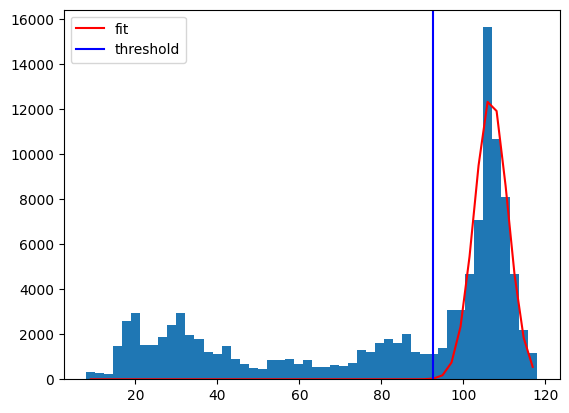

In [13]:
# thresh=90
start_time = time.time()
thresh=histogram_analysis(ROI)
end_time = time.time()
run_time = end_time - start_time
print("histogram_analysis time：", run_time*1000, "ms")

start_time = time.time()
contours=find_contours(ROI,thresh,grey)
end_time = time.time()
run_time = end_time - start_time
print("find_contours time：", run_time*1000, "ms")

start_time = time.time()
cX, cY, rect=fit_rec(contours,filename_grey)
end_time = time.time()
run_time = end_time - start_time
print("fit_rec time：", run_time*1000, "ms")
print("cX = ",cX)
print("cY = ",cY)
print("real center = [",distance_y[cY][cX],", ",distance_x[cY][cX],", ",distance[cY][cX],"]")

In [15]:
start_time = time.time()
mask = np.zeros_like(distance, dtype=np.uint8)
cv2.drawContours(mask, [np.int0(cv2.boxPoints(rect))], 0, 255, -1)
# Apply the mask to the distance image
ROI_on_distance = cv2.bitwise_and(distance, distance, mask=mask)
ROI_on_distance_x = cv2.bitwise_and(distance_x, distance_x, mask=mask)
ROI_on_distance_y = cv2.bitwise_and(distance_y, distance_y, mask=mask)
# Extract values within the ROI
ROIz_values = distance[np.where(mask == 255)]
ROIx_values = distance_x[np.where(mask == 255)]
ROIy_values = distance_y[np.where(mask == 255)]
end_time = time.time()
run_time = end_time - start_time
print("mask time：", run_time*1000, "ms")
# Convert ROI_values to a NumPy ndarray
ROIx_array = np.array(ROIx_values)
ROIy_array = np.array(ROIy_values)
ROIz_array = np.array(ROIz_values)
ROI_coordinates = np.column_stack((ROIx_array, ROIy_array, ROIz_array))
# Display the masked image
merged_ROI = cv2.merge([ROI_on_distance_x, ROI_on_distance_y, ROI_on_distance])
cv2.imshow('ROI_on_distance', merged_ROI)
cv2.waitKey(0)

mask time： 28.824806213378906 ms


-1

In [24]:
ROI_pcd=NDarray2Pcd(ROI_coordinates)
# o3d.visualization.draw_geometries([ROI_pcd])
num_neighbors = 10  # The number of neighborhood points
std_ratio =0.2 # Standard deviation multiplier
start_time = time.time()
ROI_pcd=statistical_filter(ROI_pcd,num_neighbors,std_ratio)
end_time = time.time()
run_time = end_time - start_time
print("statistical_filter time：", run_time*1000, "ms")
o3d.visualization.draw_geometries([ROI_pcd])

pcd_size:  66794
sor_pcd： PointCloud with 61154 points.
sor_noise_pcd： PointCloud with 5640 points.
statistical_filter time： 21.856069564819336 ms


In [39]:
# 估计点云平面
plane_model, inliers = ROI_pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
[a, b, c, d] = plane_model

# 获取平面法向量
normal = np.array([a, b, c])

# 获取平面上某点的坐标
point_on_plane = np.array([0, 0, -d/c])

# 计算平面位姿
z_axis = normal
y_axis = np.array([0, 1, 0])  # 假设平面上方向为y轴正方向
x_axis = np.cross(y_axis, z_axis)
rotation_matrix = np.column_stack((x_axis, y_axis, z_axis))
translation_vector = point_on_plane
transformation_matrix = np.identity(4)
transformation_matrix[:3, :3] = rotation_matrix
transformation_matrix[:3, 3] = translation_vector

print("transformation matrix：")
for row in transformation_matrix:
    rounded_row = [format(element, ".3f") for element in row]
    print(*rounded_row)

transformation matrix：
-0.039 0.000 0.014 0.000
0.000 1.000 0.999 0.000
-0.014 0.000 -0.039 -40.887
0.000 0.000 0.000 1.000
